<a href="https://colab.research.google.com/github/dnevo/ImageProcessing/blob/main/ImageProcessingRecitation_09_CannyEdgeDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.signal import convolve

In [ ]:
GITHUB_PATH = 'https://raw.githubusercontent.com/dnevo/ImageProcessing/main/images/'

def read_file(fname:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (as default, located in GitHub) and return the image 
    in a numpy array.

    Args:
        fname: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, fname)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [ ]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

# 9. Edge Detection

##9.1 Edges

Edge detection in grayscale images. ex: circle - detect its circumference.

Our main task is object detection.

In the next meeting, we will discuss lines and circles detection (Hough Transform).

In this meeting, we will present the Canny edge detection (mark the edge pixels).

How can we locate the edge pixels? - by using gradients

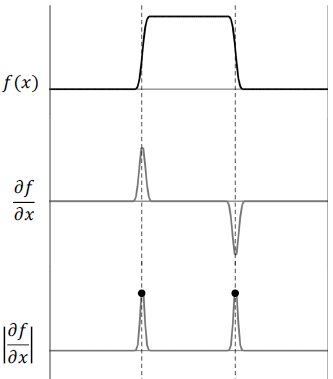

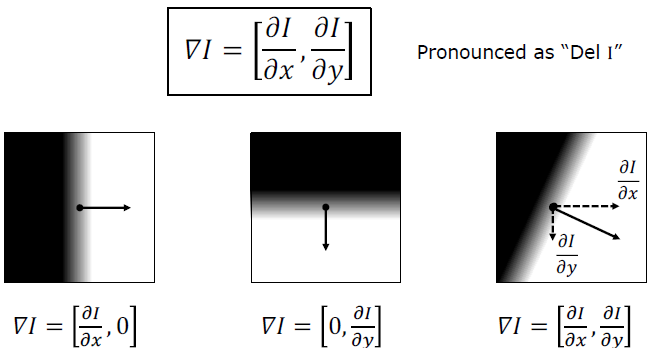

**In a continuous domain:**

$S_x=\frac{f(x+\Delta x,y)-f(x,y)}{\Delta x}$

$S_y=\frac{f(x,y+\Delta y)-f(x,y)}{\Delta y}$

$S=\sqrt{S_x^2+S_y^2}$ - the Gradient Magnitude

**In a discrete domain (Image):**

$S_x=I(x+1,y)-I(x,y)$=`convolve(img, np.array([[1,-1]]), 'same')`


$S_y=I(x,y+1)-I(x,y)$=`convolve(img, np.array([[1,-1]]).T, 'same')`

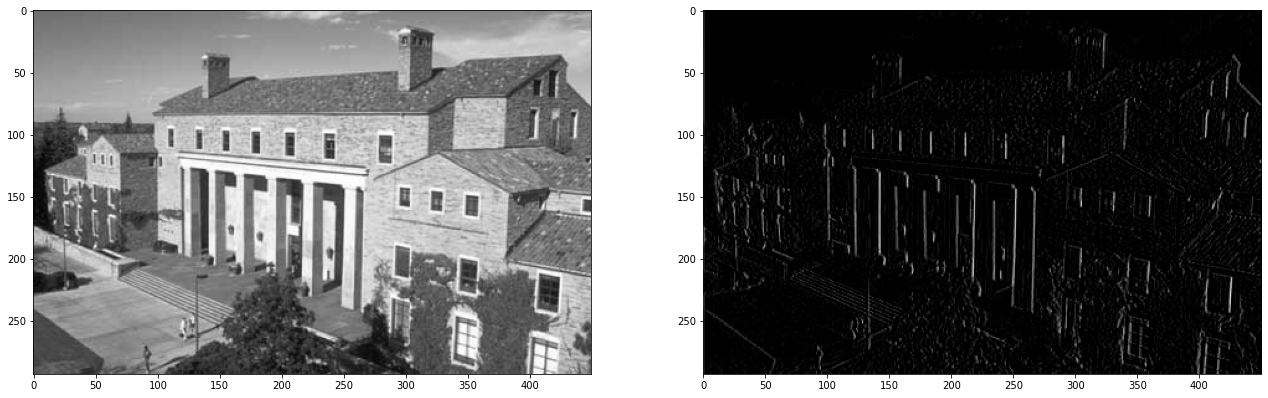

In [ ]:
img = read_file(fname='house.tiff') / 255
Sx = convolve(img, np.array([[1,-1]]), 'same')
plot_images(img, np.clip(Sx, a_min=0, a_max=1))

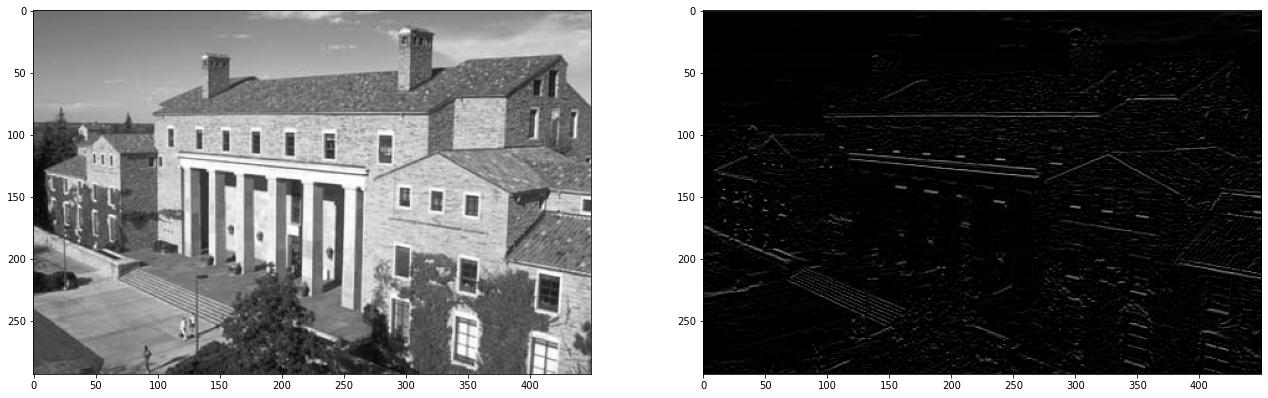

In [ ]:
img = read_file(fname='house.tiff') / 255
Sy = convolve(img, np.array([[1,-1]]).T, 'same')
plot_images(img, np.clip(Sy, a_min=0, a_max=1))

##9.2 Requirements for a good edge detection

1. Good detection: minimal False Positive (FP) and False Negative (FN).
2. Good localization: the edge localization should be accurate.
3. single response - edge width should be 1 pixel.

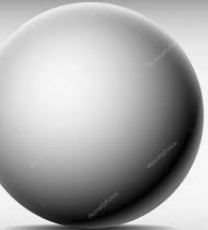

Limitation: may not have a single response: for example in shaded areas, such as illuminated balls, and in noised areas.

##9.3 Canny edge detector algorithm

### 9.3.1 - Smoothing / noise reduction

The edge detection operation is sensitive to noise. A Gaussian filter is used to remove noise from the image:

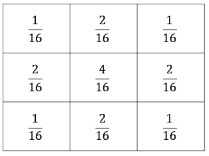

###9.3.2 Gradients matrix ($S$)


$S=\sqrt{S_x^2+S_y^2}$ - the Gradient Magnitude

We go over the $S$ matrix, and any point above a predefined threshold will be considered an edge pixel.

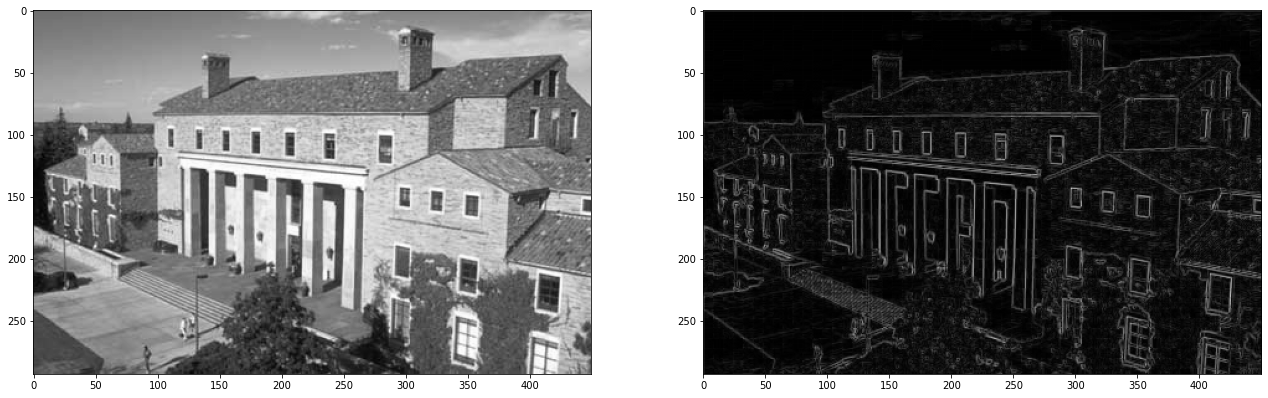

In [ ]:
S = np.sqrt(Sx*Sx + Sy*Sy)
plot_images(img, S)

###9.3.3 Hysteresis Thresholding (with double passing)

It might be difficult to fulfill both low FP and FN with a single Threshold:
- setting it too high will result in a high FN rate.
- setting it too low will result in a high FP.

Therefore, we set hysteresis threshold, i.e. 2 thresholds: `t_high` and `t_low`
- Any edges with intensity greater than `t_high` are the sure edges
- Any edges with intensity less than `t_low` are sure to be non-edges,
- The edges between `t_high` and `t_low` are classified as edges, only if they are connected to a definitive edge.

The alogorithm:
1. assign `t_high` and `t_low` hyperparameters
2. create `img_e`, edges binary matrix, initialized with zeros.
3. Thresholding pass 1 (from top-left to bottom-right) – on $S$
 - case `S[i,j] < t_low: img_e[i,j] = 0`
 - case `S[i,j] > t_high: img_e[i,j] = 1`
 - case `t_low <= S[i,j] <= t_high and any img_e[i-1:i+2, j-1,j+2]==1: img_e[i,j] = 1`
 - otherwise `img_e[i,j] = 0`
4. Thresholding pass 2 (from bottom-right  to top-left) – on $S$.
 - Repeat same as in pass 1.

### 9.3.4 Computing magnitude and orientation of the gradients

Horizontal and vertical filters are then applied to the image to compute the edge gradient magnitude and direction for each pixel. The gradient angle (direction) computed is then rounded to one of four angles for each pixel.

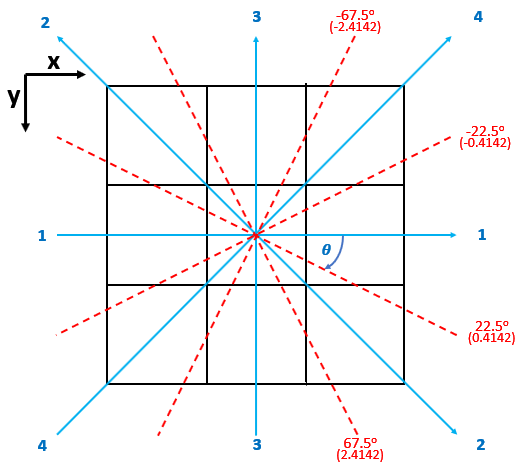

In order to satisfy the single response requirement, we would like to select just one edge pixel in the gradient direction, calculated by:

$$tg\space\theta=\frac{S_y}{S_x}$$

We define the 4 main directions by:

$1: -0.4142 <=tg\space\theta <=0.4142$

$2: 0.4142 <=tg\space\theta <=2.4142$

$3: |tg\space\theta| >2.4142$

$4: -2.4142 <=tg\space\theta <=0.4142$

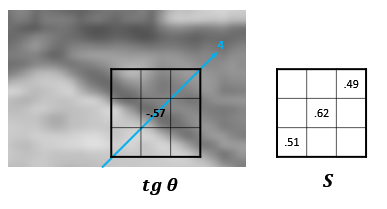

The alogorithm:

1. Create matrix $tg\space\theta$ `tg_theta = Sy / Sx`. Note: remember to avoid divide by zero!
2. Compute matrix `grad_dir` (gradient main directions {1,2,3,4}) – using `tg_theta`

### 9.3.5 Non Maximum Suppression (NMS)

Loop on all pixels:
1. `if img_e[i,j] == 0: continue`
2. From the value of `tg_theta` define the gradient direction (quadrant: 1,2,3,4)
3. compare to the 2 other pixels in that direction. If not a maximum of them, it is not an edge pixel, therefore set: `img_e[r, c] = 0`

###9.3.6 The algorithm

**Step 1: Smooth the image with a filter:**
```python
use a Gauss filter:
    1 2 1
    2 4 2  / 16
    1 2 1
input: img
output: img_s
```
**Step 2: create S (gradients matrix) and tg_theta (grad angles)**
```python
input: img_s

Sx = convolve(img_s, np.array([[1, -1]]), 'same')
Sy = convolve(img_s, np.array([[1, -1]]).T, 'same')
S = np.sqrt(Sx*Sx + Sy*Sy)
Sx[Sx==0] = 0.0001 #to avoid zero division
tg_theta = Sy / Sx    # create matrix of grad angles
```

**Step 3: thresholding**
```python
create img_e - edges matrix with size of img, filled with zeros
```

**Step 3.1: pass 1: from top-left to bottom-right:**
```python
scan S (without first and last rows and columns)
    if S[i,j] < t_low: img_e[i,j] = 0
    if S[i,j] > t_high:img_e[i,j] = 1
    else: img_e[i,j] = np.any(img_e[r-1:r+2, c-1:c+2])
```
**Step 3.2: pass 2: from bottom-right to top-left:**
```python
same as in 3.1 ...
```

**Step 3.3: compute the grad main directions (1..4)**
```python
create grad_dir - matrix with size of img, filled with zeros
scan tg_theta:
    if -0.4142 <= tg_theta[r, c] <= 0.4142: grad_dir[r, c] = 1
    if  0.4142 <  tg_theta[r, c] <= 2.4142: grad_dir[r, c] = 2
    if            tg_theta[r, c] >  2.4142: grad_dir[r, c] = 3
    if -2.4142 <= tg_theta[r, c] < -0.4142: grad_dir[r, c] = 4
```
**Step 3.4: Non Max Suppress (NMS):**
```python
scan img_e:
    if img_e[r, c] == 0: continue
    if grad_dir[r, c] == 1:
        if S[r, c] < max(S[r  ,c-1], S[r  ,c+1]): img_e[r, c] = 0
    if grad_dir[r, c] == 2:
        if S[r, c] < max(S[r-1,c-1], S[r+1,c+1]): img_e[r, c] = 0
    if grad_dir[r, c] == 3:
        if S[r, c] < max(S[r-1,c  ], S[r+1,c  ]): img_e[r, c] = 0
    if grad_dir[r, j] == 4
        if S[r, c] < max(S[r-1,c+1], S[r+1,c-1]): img_e[r, c] = 0
```

##9.4 Canny Edge detector using OpenCV

In [ ]:
img = read_file('balls4.tiff').astype('uint8')

In [ ]:
import cv2

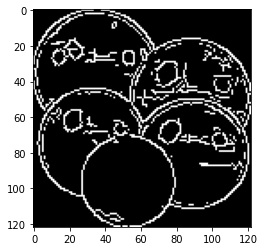

In [ ]:
edges =cv2.Canny(image=img, threshold1=40, threshold2=140)
plt.imshow(edges, cmap='gray');

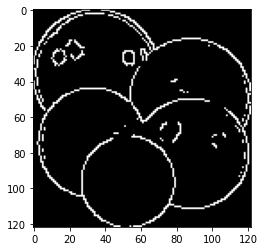

In [ ]:
edges =cv2.Canny(image=img, threshold1=230, threshold2=240)
plt.imshow(edges, cmap='gray');

##9.5 Dynamic Plot

In [ ]:
import plotly.express as px
fig = px.imshow(S, color_continuous_scale='gray')
fig.update_layout(coloraxis_showscale=False)